## Layer-Wise Relevance Propagation Numpy Implementation
Mirror notebook of - https://git.tu-berlin.de/gmontavon/lrp-tutorial/-/blob/main/tutorial.ipynb
<br>
Overview paper - https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10
<br><br>
Based on a simple deep rectifier network trained on the MNIST handwritten digits data
<br><br><br>
#### Loading 12 example MNIST digits

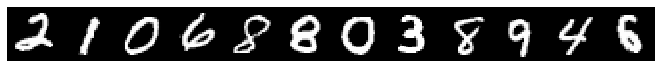

In [2]:
import util
X,T = util.loaddata()

%matplotlib inline
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

Each digit is stored as a 784-dimensional vector of pixel values, where "-1.0" corresponds to black and "+1.0" corresponds to white.


#### Predicting classes of MNIST digits
We retrieve the parameters of a fully connected neural network with layer sizes 784-300-100-10 with ReLU activations for each hidden layer.

This network acieves an error of 1.6%.

In [3]:
W,B = util.loadparams()
L = len(W) 

Computing the forward pass (sequence of matric multiplications and nonlinearities)

In [4]:
import numpy
A = [X]+[None]*L
for l in range(L):
    A[l+1] = numpy.maximum(0,A[l].dot(W[l])+B[l])

Note that this code has added an additional top-layer ReLU activation compared to the original neural network. This however doesn't affect computations when looking at positive output scores. The top layer activations are scores measuring the evidence the network has found for each class. 
<br><br>
Checking the first three digits and scores for each class:

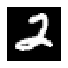

[0] 0.0  [1] 3.6  [2] 49.1  [3] 8.9  [4] 0.0  [5] 0.0  [6] 0.0  [7] 1.4  [8] 1.6  [9] 0.0


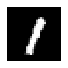

[0] 0.0  [1] 27.0  [2] 0.0  [3] 0.0  [4] 5.3  [5] 0.0  [6] 0.0  [7] 13.0  [8] 8.1  [9] 2.3


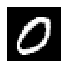

[0] 49.1  [1] 0.0  [2] 10.6  [3] 0.0  [4] 0.0  [5] 0.2  [6] 0.0  [7] 3.0  [8] 0.0  [9] 9.2


In [5]:
for i in range(3):
    util.digit(X[i].reshape(28,28),0.75,0.75)
    p = A[L][i]
    print("  ".join(['[%1d] %.1f'%(d,p[d]) for d in range(10)]))

#### Explaining the above predictions using LRP

We implement the LRP procedure from the top to the bottom of the network in the following steps:
<br><br>
1.Create a list to store relevance scores at each level. The top-level scores are set to the top-layer activations which are multiplies by a label indicator to retain only the actual class evidence.

In [6]:
R = [None]*L + [A[L]*(T[:,None]==numpy.arange(10))]

The LRP-0, LRP-ϵ, and LRP-γ rules described in the overview paper (Section 10.2.1) are special cases of the more general propagation rule - 

<img src="http://latex.codecogs.com/svg.latex?R_j = \sum_k \frac{a_j \rho(w_{jk})}{\epsilon + \sum_{0,j} a_j \rho(w_{jk})} R_k">

where ρ is a function that transform the weights, and ϵ is a small positive increment. 
<br>
We define two helper functions that perform the weight transformation and the incrementation. In practice, we would like to apply different rules at different layers (Section 10.3). Therefore, we also give the layer index "<code>l</code>" as argument to these functions.

In [7]:
def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * numpy.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

These functions helps us to reduce the general rule to LRP-0 for the top-layer, to LRP-ϵ with ϵ = 0.1std for the layer just below, and to LRP-γ with γ=0.1 for the layer before.
<br><br> 
The general rule can be decomposed to a sequence of four computations:

<p>
<img src="http://latex.codecogs.com/svg.latex?
\begin{align*}
\forall_k:~z_k = {\textstyle \epsilon + \sum_{0,j}} a_j \rho(w_{jk}) & (\text{step }1)\\
\forall_k:~s_k = R_k / z_k \qquad & (\text{step }2)\\
\forall_j:~c_j = {\textstyle \sum_k} \rho(w_{jk}) s_k \qquad & (\text{step }3)\\
\forall_j:~R_j = a_j \cdot c_j \qquad & (\text{step }4)
\end{align*}
">
</p>
<br><br>
We iterate over the layers in reverse order, and at each layer apply the above mentioned sequence of computations.

In [8]:
for l in range(1,L)[::-1]:

    w = rho(W[l],l)
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w)+b,l)    # step 1
    s = R[l+1] / z               # step 2
    c = s.dot(w.T)               # step 3
    R[l] = A[l]*c                # step 4

**Important**<br>
The loop above stops one layer before the pixels because we need to apply an alternate propagation rule that properly handles pixel values received as input (section 10.3.2). We apply the following zB-rule described by:<br>
<img src="http://latex.codecogs.com/svg.latex?R_i = \sum_j \frac{a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-}{\sum_{i} a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-} R_j">


<p>In this rule, <i>l<sub>i</sub></i> and <i>h<sub>i</sub></i> are the lower and upper bounds of pixel values, i.e. "-1" and "+1", and (·)<sup>+</sup> and (·)<sup>–</sup> are shortcut notations for max(0,·) and min(0,·). The zB-rule can again be implemented with a four-step procedure similar to the one used in the other layers. Here, we need to create two copies of the weights, and also create arrays of pixel values set to <i>l<sub>i</sub></i> and <i>h<sub>i</sub></i> respectively:</p>

In [9]:
w  = W[0]
wp = numpy.maximum(0,w)
wm = numpy.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9        # step 1
s = R[1]/z                                        # step 2
c,cp,cm  = s.dot(w.T),s.dot(wp.T),s.dot(wm.T)     # step 3
R[0] = A[0]*c-lb*cp-hb*cm                         # step 4

We have now reached the bottom layer and the pixel-wise relevance scores have been obtained and can be rendered as a heatmap.

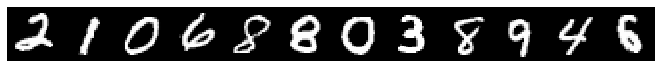

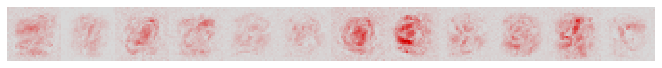

In [10]:
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
util.heatmap(R[0].reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

Relevant pixels are highlighted in red. Pixels that contribute negatively to the prediction, if any, are shown in blue. On most digits, we find that the digit itself is highlighted, as well as some parts of the background. For example, two red horizontal bars next to the digit "3", highlighting the fact that if those pixels would be different, the digit 3 would likely turn into a "8". Same for the vertical bar above the digit "4" that supports the class "4" instead of the class "9".

### Calculating pixel score

In [11]:
#Extract wieghts of the first layer
weights_one = []
weights_one_abs = []
for w in range(0,784):
    weights_one.append(W[0][w][0])
    weights_one_abs.append(abs(W[0][w][0]))

#Get Pixel Scores using first layer weights
P1 = []
P2 = []
for image in range(0,12):
    P1.append(X[image]*weights_one)
    P2.append(X[image]*weights_one_abs)

#Convert list to numpy arrays
N1 = numpy.array(P1)
N2 = numpy.array(P2)

### Normalising the scores

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#Scale the pixel scores
N1_scaled = scaler.fit_transform(N1)
N2_scaled = scaler.fit_transform(N2)

### Visualising the scores as heatmaps
<br>
LRP Score using zB-rule

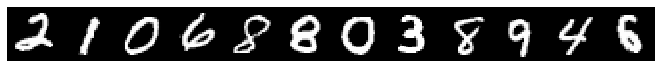

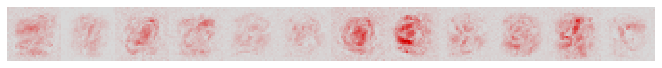

In [13]:
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
util.heatmap(R[0].reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

First-layer weights without modification (unscaled)

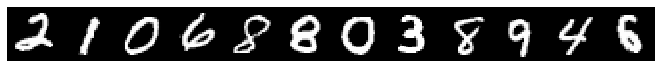

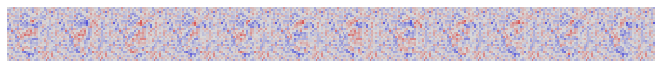

In [14]:
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
util.heatmap(N1.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

First-layer weights using absolute value (unscaled)

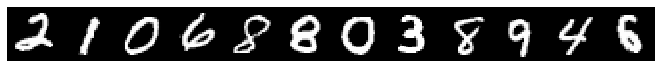

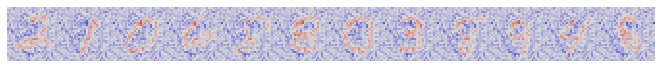

In [15]:
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
util.heatmap(N2.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

First-layer weights without modification (scaled)

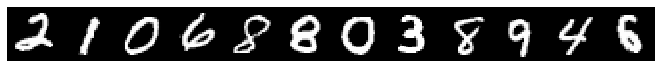

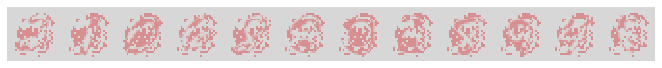

In [16]:
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
util.heatmap(N1_scaled.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

First-layer weights using absolute value (scaled)

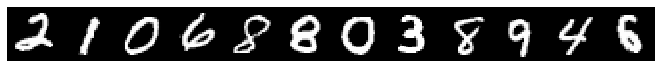

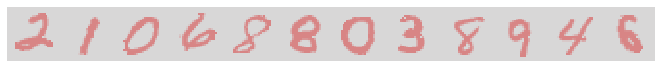

In [17]:
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
util.heatmap(N2_scaled.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

### Correlation analysis

zB-Rule and Unscaled first-layer weights

In [18]:
from scipy.stats import pearsonr

for image in range(0,12):
    corr,prob= pearsonr(N1[image],R[0][image])
    print(f'r = {corr} and p = {prob}')

r = 0.025054062694781724 and p = 0.4836123528740141
r = 0.0017807422431262918 and p = 0.9602966953601371
r = 0.20075837473622765 and p = 1.4272264718277413e-08
r = -0.1001275580680322 and p = 0.005013686709182637
r = -0.009219498968920407 and p = 0.7966079114885716
r = -0.07253502572437137 and p = 0.04231434908197192
r = 0.2254376466230059 and p = 1.719059462060973e-10
r = 0.09702672740292546 and p = 0.0065513096117288975
r = 0.003274614989002212 and p = 0.9270610058365099
r = 0.04219326109468023 and p = 0.2379796007099146
r = -0.0523402229001213 and p = 0.143141603242434
r = -0.16512148352697675 and p = 3.3522489847380614e-06


zB-Rule and Unscaled first-layer weights absolute values

In [19]:
for image in range(0,12):
    corr,prob= pearsonr(N2[image],R[0][image])
    print(f'r = {corr} and p = {prob}')

r = 0.12937381634435785 and p = 0.0002812755787293552
r = 0.24349320684942713 and p = 4.8052933455229725e-12
r = 0.20344608077782286 and p = 9.05105955541941e-09
r = 0.15480598251678618 and p = 1.3372190399820988e-05
r = 0.15900504698974163 and p = 7.693959133102699e-06
r = 0.32470705934208977 and p = 1.045784632291248e-20
r = 0.1879916170024457 and p = 1.1409324409802961e-07
r = 0.18595305087022868 and p = 1.569766379727329e-07
r = 0.20794766595456318 and p = 4.162269318320335e-09
r = 0.2030323836664112 and p = 9.712270286514504e-09
r = 0.1584268436078619 and p = 8.309472781721243e-06
r = 0.12740053011326255 and p = 0.00034875183422587307


zB-rule and Scaled first-layer weights

In [20]:
for image in range(0,12):
    corr,prob= pearsonr(N1_scaled[image],R[0][image])
    print(f'r = {corr} and p = {prob}')

r = 0.40333429612374594 and p = 4.984052194847952e-32
r = 0.3918585189525525 and p = 3.552687373879375e-30
r = 0.5265722337841514 and p = 3.890467379233869e-57
r = 0.27686899820263094 and p = 2.9076937794229828e-15
r = 0.4160707959960755 and p = 3.584942674071385e-34
r = 0.30519392033913917 and p = 2.306742910656042e-18
r = 0.5492269014605391 and p = 5.58114922464013e-63
r = 0.47115029712863155 and p = 1.4352834197900018e-44
r = 0.37905868927581965 and p = 3.410922972191814e-28
r = 0.45551764212456547 and p = 2.0142109539319526e-41
r = 0.30441736692579735 and p = 2.835941962630925e-18
r = 0.17971053404578452 and p = 4.0806039804535864e-07


zB-Rule and Scaled first-layer weights absolute values

In [21]:
for image in range(0,12):
    corr,prob= pearsonr(N2_scaled[image],R[0][image])
    print(f'r = {corr} and p = {prob}')

r = 0.32236328627605804 and p = 2.042466198402976e-20
r = 0.45875357928035476 and p = 4.6340473861047675e-42
r = 0.3600300706372316 and p = 2.094471886368531e-25
r = 0.3351748790058854 and p = 4.89410961028476e-22
r = 0.32242523807865897 and p = 2.0067967788570533e-20
r = 0.49494886609848093 and p = 1.1014552810130642e-49
r = 0.33783155382388175 and p = 2.2076826730823432e-22
r = 0.3447770524003191 and p = 2.6548923545777794e-23
r = 0.4183025475161652 and p = 1.4769201329968665e-34
r = 0.4067555952347913 and p = 1.351959480665688e-32
r = 0.35901644402611455 and p = 2.9134828873678484e-25
r = 0.2917532219955225 and p = 7.547552845089277e-17


### Correlation between first-layer weights and relevance scores

In [34]:
#Reshape the weights vector
weights_array = []
weights_array_abs = []
for i in range(0,12):
    weights_array.append(weights_one)
    weights_array_abs.append(weights_one_abs)

In [48]:
#Convert to numpy array
weights_array = numpy.array(weights_array)
weights_array_abs = numpy.array(weights_array_abs)

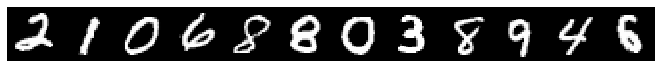

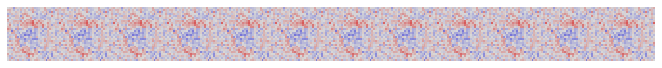

In [49]:
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
util.heatmap(weights_array.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

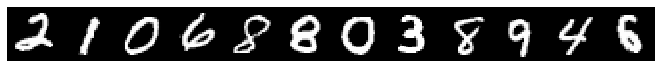

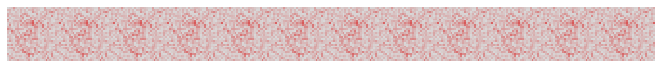

In [50]:
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
util.heatmap(weights_array_abs.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

First layer weights and Relevance Scores

In [51]:
for image in range(0,12):
    corr,prob= pearsonr(weights_array[image],R[0][image])
    print(f'r = {corr} and p = {prob}')

r = -0.048669298375089695 and p = 0.1733958955816307
r = -0.041582443670482416 and p = 0.2448482785317105
r = -0.10068321676436771 and p = 0.004775416800690835
r = 0.04051428387053827 and p = 0.25719108562980875
r = -0.03672360245529217 and p = 0.3044361732459617
r = -0.06005546196309036 and p = 0.09288207821140654
r = -0.12696217619008127 and p = 0.00036566436191546014
r = -0.09102581499420004 and p = 0.010773787428689912
r = -0.040436159225913475 and p = 0.25811045045961084
r = -0.05461686670839075 and p = 0.126519285113077
r = -0.030304582315580572 and p = 0.39678944992507836
r = 0.06161046838889153 and p = 0.08471170502037927


First layer weights absolute values and Relevance Scores

In [52]:
for image in range(0,12):
    corr,prob= pearsonr(weights_array_abs[image],R[0][image])
    print(f'r = {corr} and p = {prob}')

r = 0.18299343421991082 and p = 2.479190590699974e-07
r = 0.1403076039522779 and p = 8.085239665885582e-05
r = 0.1139969239476793 and p = 0.0013874508029501507
r = 0.14249597317370263 and p = 6.228819211004605e-05
r = 0.1286800042196231 and p = 0.0003034704384580835
r = 0.16035367468624126 and p = 6.422916327771074e-06
r = 0.13842516479162756 and p = 0.0001008844761801019
r = 0.1810881944972796 and p = 3.314244809124837e-07
r = 0.18452507263023882 and p = 1.9588300156134688e-07
r = 0.15233446261143418 and p = 1.839072133124848e-05
r = 0.156127736614197 and p = 1.1254068252561417e-05
r = 0.18437413994551602 and p = 2.0050126431522658e-07
